Our goal here is to managed to do cluster our customers based on 3 main features:
- Recency: when was the last time the customer bought something,
- Frequency: how often a customer order products in a given timeframe,
- Monetary: how much does the customer spend in a given timeframe.
This will allow us to later see when our clustering model will need to be updated.

We will also cluster our customers for each of those aforementioned features, assign a score to them and segment our based on their value (Customer Lifetime Value).

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from datetime import timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
# To remove some warnings (setting with a copy)
pd.options.mode.chained_assignment = None

Considering the fact that we do not have a lot of data, we will use every data available to us and we will not focus only on the customers based in the UK.

In [3]:
# Loading data
df = pd.read_csv('static/customer_segmentation.csv', encoding='latin1')
df.head()

InvoiceNo StockCode                          Description  Quantity   
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6  \
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [4]:
# Checking the shape of our data
df.shape

(541909, 8)

We change our InvoiceDate column into a datetime column for easier use.

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'] = df['InvoiceDate'].dt.to_period('D')
df['InvoiceDate'] = df['InvoiceDate'].astype('datetime64[ns]')

In [6]:
# We check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
# We check missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

We have no way to properly fill the missing values in our "CustomerID", we drop those rows.

In [8]:
df = df[df['CustomerID'].notnull()]
df.shape

(406829, 8)

In [9]:
# We check that indeed we don't have missing values anymore
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

We drop columns that we won't use.

In [10]:
df = df.reset_index()
df = df.drop(['StockCode', 'Country', 'index'], axis=1)
df.shape

(406829, 6)

Now, we remove the order amounts that have a negative value (discounts or returned orders).

In [11]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [12]:
data_null = df[df['TotalAmount'] < 0]
data_null['Quantity'] = - data_null['Quantity']
data_null['TotalAmount'] = - data_null['TotalAmount']
data_null = data_null[['CustomerID', 'Description', 'Quantity', 'UnitPrice', 'TotalAmount']]

data_not_null = df[df['TotalAmount'] >= 0]
data_not_null['Quantity'] = - data_not_null['Quantity']
data_not_null['TotalAmount'] = - data_not_null['TotalAmount']
data_not_null = data_not_null[['CustomerID', 'Description', 'Quantity', 'UnitPrice', 'TotalAmount']]

df_concat = pd.concat([data_null, data_not_null])
df_concat = df_concat.drop_duplicates()
df_concat = df_concat.drop('TotalAmount', axis=1)

data_concat = pd.concat([df_concat, df])
null_quantity = data_concat[data_concat['Quantity'] < 0]
data_concat = data_concat.drop(null_quantity.index)
data_concat = data_concat.drop_duplicates(subset=['CustomerID', 'Description', 'Quantity', 'UnitPrice', 'TotalAmount'])
data_concat.head()

CustomerID                         Description  Quantity  UnitPrice   
47     17850.0           HAND WARMER RED POLKA DOT         6       1.85  \
48     17850.0              HAND WARMER UNION JACK         6       1.85   
49     17850.0  WHITE HANGING HEART T-LIGHT HOLDER         6       2.55   
50     17850.0                 WHITE METAL LANTERN         6       3.39   
51     17850.0      CREAM CUPID HEARTS COAT HANGER         8       2.75   

   InvoiceNo InvoiceDate  TotalAmount  
47    536372  2010-12-01        11.10  
48    536372  2010-12-01        11.10  
49    536373  2010-12-01        15.30  
50    536373  2010-12-01        20.34  
51    536373  2010-12-01        22.00

# Function for RFM

Now, we will define several functions : a function to subset our dataframe based on dates and then functions to create our RFM features.

## Subset dates

In [13]:
def data_subset(data, beginning='2010-12-01', end='2011-12-09'):
    
    beginning = pd.to_datetime(beginning)
    end = pd.to_datetime(end)
    
    # Subsetting
    data = data[(data['InvoiceDate'] >= beginning) & (data['InvoiceDate'] <= end)]

    return data

## Recency

In [14]:
def recency(data):
    new_data = data.copy()
    last_day = new_data['InvoiceDate'].max()

    recency = []
    for value in new_data['InvoiceDate']:
        result = last_day - value
        recency.append(result.days)
    
    new_data['Recency'] = recency

    return new_data

## Frequency

In [15]:
def frequency(data):
    new_data = data.copy()

    frequencies_series = new_data.groupby('CustomerID')['InvoiceNo'].unique()

    nb_orders = []
    for value in frequencies_series.values:
        nb_orders.append(len(value))

    indexes = frequencies_series.index

    df_freq = pd.DataFrame(nb_orders, columns=['NbOrder'])
    df_freq['CustomerID'] = indexes

    df_merge = new_data.merge(df_freq, on='CustomerID')

    df_merge['Frequency'] = df_merge['NbOrder']

    return df_merge

## Monetary

In [16]:
def monetary(data):
    new_data = data.copy()
    new_data['Monetary'] = new_data['Quantity'] * new_data['UnitPrice']

    return new_data

## RFM function

In [17]:
def rfm(data):
    new_data = data.copy()

    new_data = recency(new_data)
    new_data = frequency(new_data)
    new_data = monetary(new_data)

    df_rfm = new_data[['CustomerID', 'Recency', 'Frequency', 'Monetary']]

    monetary_sum = df_rfm.groupby('CustomerID')['Monetary'].sum()
    monetary_sum = pd.DataFrame(monetary_sum)
    monetary_sum = monetary_sum.reset_index()

    df_rfm = df_rfm.drop('Monetary', axis=1)
    df_rfm = df_rfm.merge(monetary_sum, on='CustomerID')
    df_rfm = df_rfm.sort_values(['CustomerID', 'Recency'])
    df_rfm = df_rfm.drop_duplicates(subset='CustomerID')
    df_rfm = df_rfm.reset_index()
    df_rfm = df_rfm.drop(['index'], axis=1)

    return df_rfm

# Scoring of our features:

We want to know in how many clusters we can segment our customers for each of our features. So, we apply our rfm function to our data and check the best value for each feature.

In [18]:
df_cluster_features = data_subset(data_concat, '2010-12-01', '2011-09-01')
df_cluster_features = rfm(df_cluster_features)
df_cluster_features_no_prep = df_cluster_features.copy()
df_cluster_features.head(3)

CustomerID  Recency  Frequency  Monetary
0     12347.0       30          3    463.41
1     12348.0      149          1     40.00
2     12352.0      163          2    160.33

In [19]:
df_cluster_features['Frequency'] = np.log(df_cluster_features['Frequency'])
df_cluster_features['Monetary'] = np.log(df_cluster_features['Monetary'])

# Scaling
scaler_ini = StandardScaler()
scaler_ini.fit(df_cluster_features[['Recency', 'Frequency', 'Monetary']])

df_cluster_features[['Recency', 'Frequency', 'Monetary']] = scaler_ini.transform(df_cluster_features[['Recency', 'Frequency', 'Monetary']])
df_cluster_features = pd.DataFrame(df_cluster_features, columns=['Recency', 'Frequency', 'Monetary'])
df_cluster_features.head()

Recency  Frequency  Monetary
0 -0.565754   0.360697  0.983468
1  1.243642  -0.963586 -0.465036
2  1.456513  -0.128057  0.355885
3  1.198027  -0.963586 -0.411374
4  0.346547   0.360697  0.746318

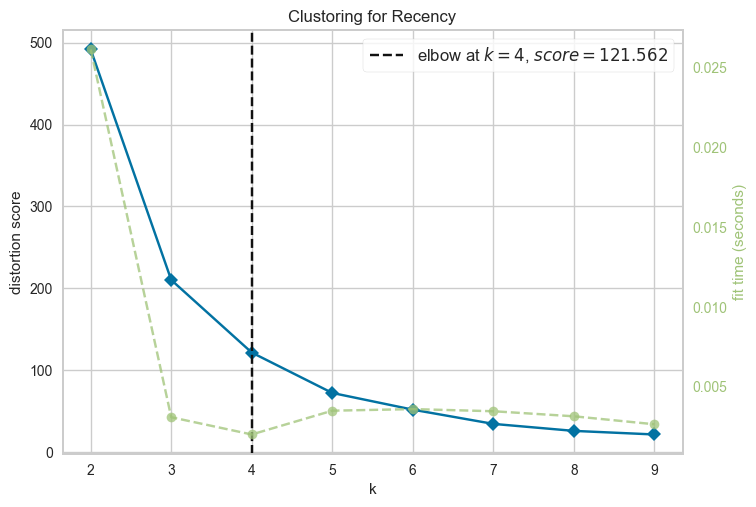

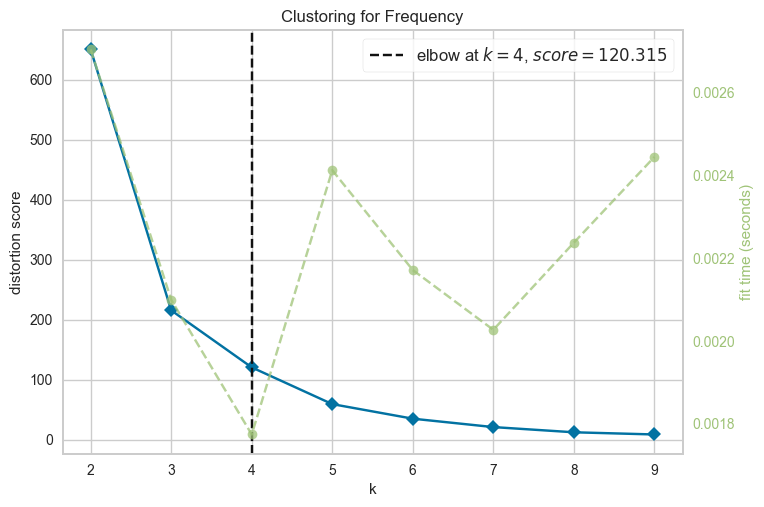

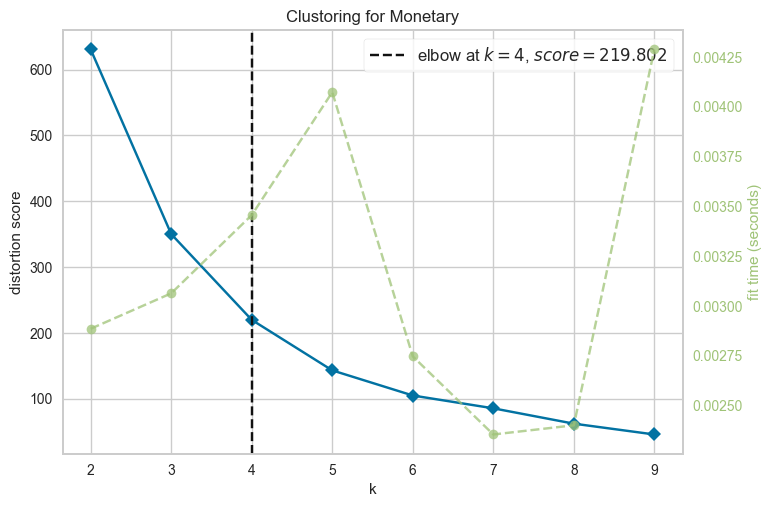

In [20]:
for col in ['Recency', 'Frequency', 'Monetary']:
    model = KMeans(n_init='auto', random_state=24)
    visualizer = KElbowVisualizer(model, k=(2, 10), title=f'Clustoring for {col}')

    visualizer.fit(df_cluster_features[[col]])
    visualizer.show()

Now, we can create a function to cluster each feature, assign a score to them and create a new categorical column in our dataframe representing the Customer Lifetime Value.

In [21]:
def scoring_cluster(data):

    new_data = data.copy()

    for col in ['Recency', 'Frequency', 'Monetary']:
        kmeans_col = KMeans(n_init='auto', n_clusters=4, random_state=24)
        kmeans_col.fit(new_data[[col]])
        new_data[f'Cluster{col}'] = kmeans_col.labels_

        rfm_values = []
        for i in range(4):
            rfm_values.append((new_data[new_data[f'Cluster{col}'] == i][col].min(), new_data[new_data[f'Cluster{col}'] == i][col].max()))

        if col == 'Recency':

            ordered_rfm_values = []

            for i in enumerate(sorted(rfm_values, reverse=True)):
                ordered_rfm_values.append(i)

            score_rfm_values = []
            for value in new_data[col]:
                for i in range(4):
                    if (value >= ordered_rfm_values[i][1][0]) & (value <= ordered_rfm_values[i][1][1]):
                        score_rfm_values.append(i)

            new_data[f'Score{col}'] = score_rfm_values

        else:
            ordered_rfm_values = []

            for i in enumerate(sorted(rfm_values)):
                ordered_rfm_values.append(i)

            score_rfm_values = []
            for value in new_data[col]:
                for i in range(4):
                    if (value >= ordered_rfm_values[i][1][0]) & (value <= ordered_rfm_values[i][1][1]):
                        score_rfm_values.append(i)

            new_data[f'Score{col}'] = score_rfm_values
    
    new_data['ScoreCluster'] = new_data['ScoreRecency'] + new_data['ScoreFrequency'] + new_data['ScoreMonetary']
    new_data = new_data.drop(['ScoreRecency', 'ScoreFrequency', 'ScoreMonetary', 'ClusterRecency', 'ClusterFrequency', 'ClusterMonetary'], axis=1)

    new_values = []
    for value in new_data['ScoreCluster']:
        if value <= 3:
            new_values.append('LowValue')
        elif (value > 3) & (value < 7):
            new_values.append('MidValue')
        elif value >= 7:
            new_values.append('HighValue')

    new_data['ScoreCluster'] = new_values
    
    return new_data

## Clustering of our customers via scoring

In [22]:
# We apply our new function
df_cluster_features = scoring_cluster(df_cluster_features)
df_cluster_features.describe()

Recency     Frequency      Monetary
count  1.689000e+03  1.689000e+03  1.689000e+03
mean  -8.413768e-18  5.048261e-17 -4.291022e-16
std    1.000296e+00  1.000296e+00  1.000296e+00
min   -1.021905e+00 -9.635861e-01 -3.159182e+00
25%   -7.634196e-01 -9.635861e-01 -6.381039e-01
50%   -3.528842e-01 -1.280567e-01  2.970041e-02
75%    4.681866e-01  7.074728e-01  6.712416e-01
max    3.144269e+00  4.447080e+00  3.568366e+00

In [23]:
df_cluster_features_no_prep['ScoreCluster'] = df_cluster_features['ScoreCluster']
df_cluster_features_no_prep['ScoreCluster'].value_counts()

ScoreCluster
MidValue     627
HighValue    534
LowValue     528
Name: count, dtype: int64

In [24]:
# We get our features and our target
X = df_cluster_features_no_prep.drop('ScoreCluster', axis=1)
y = df_cluster_features_no_prep['ScoreCluster']

In [25]:
# We split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=24)

In [26]:
# We apply our preprocessing
X_train[['Frequency', 'Monetary']] = np.log(X_train[['Frequency', 'Monetary']])
X_test[['Frequency', 'Monetary']] = np.log(X_test[['Frequency', 'Monetary']])

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
# We try some models
lr = LogisticRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   HighValue       0.95      0.95      0.95       107
    LowValue       0.94      0.91      0.92       106
    MidValue       0.88      0.91      0.90       125

    accuracy                           0.92       338
   macro avg       0.93      0.92      0.92       338
weighted avg       0.92      0.92      0.92       338



In [28]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   HighValue       1.00      1.00      1.00       107
    LowValue       1.00      0.98      0.99       106
    MidValue       0.98      1.00      0.99       125

    accuracy                           0.99       338
   macro avg       0.99      0.99      0.99       338
weighted avg       0.99      0.99      0.99       338



# Clustering of our customers via KMeans

In [29]:
# We can reuse the preprocessed dataframe from before and drop the "ScoreCluster" column
df_cluster_features = df_cluster_features.drop('ScoreCluster', axis=1)
df_cluster_features.head()

Recency  Frequency  Monetary
0 -0.565754   0.360697  0.983468
1  1.243642  -0.963586 -0.465036
2  1.456513  -0.128057  0.355885
3  1.198027  -0.963586 -0.411374
4  0.346547   0.360697  0.746318

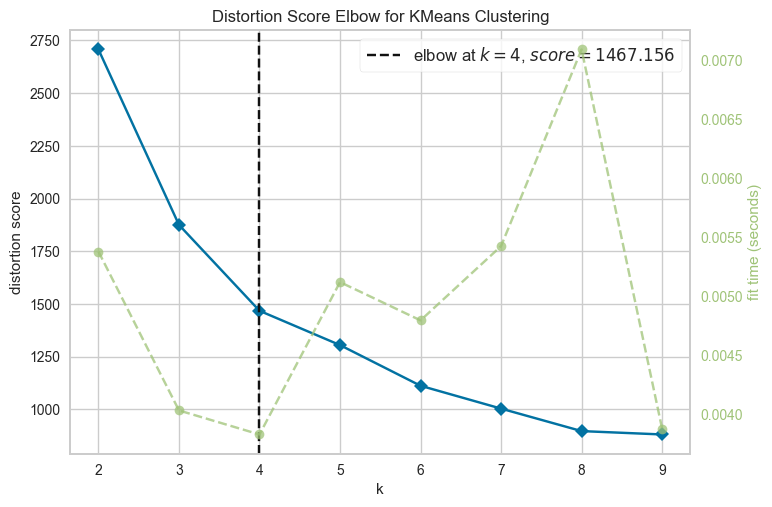

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
# We then apply a clustering on the whole dataset
model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=(2, 10))

visualizer.fit(df_cluster_features)
visualizer.show()

In [31]:
# We split our customers into 4 clusters and check how many customers there are in each cluster
kmeans = KMeans(n_init='auto', n_clusters=4, random_state=60)
kmeans.fit(df_cluster_features)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([267, 585, 528, 309]))

/Users/victorerrotaberea/.pyenv/versions/3.10.4/envs/artefact/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


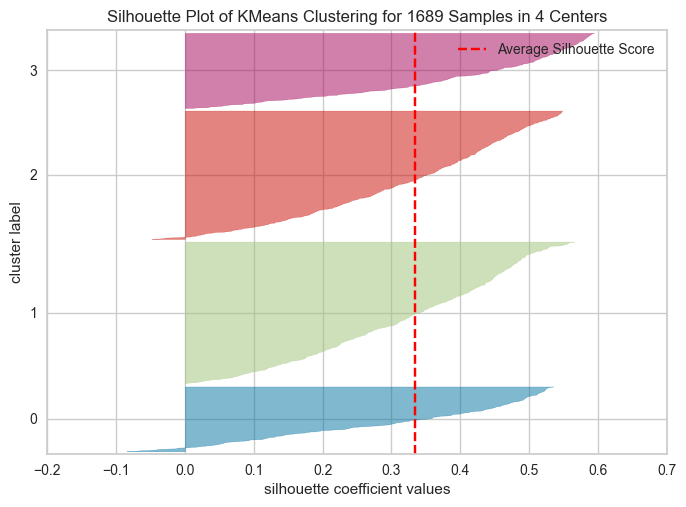

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1689 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [32]:
# We check the silhouette score of our clusters
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(df_cluster_features)
visualizer.show()

What are those clusters?

In [33]:
# We can reuse our dataframe from before and drop the features we won't use
df_cluster_features_no_prep = df_cluster_features_no_prep.drop(['CustomerID', 'ScoreCluster'], axis=1)
df_cluster_features_no_prep['Cluster'] = kmeans.labels_
df_cluster_features_no_prep.head()

Recency  Frequency  Monetary  Cluster
0       30          3    463.41        1
1      149          1     40.00        0
2      163          2    160.33        0
3      146          1     43.80        0
4       90          3    310.30        1

In [34]:
df_cluster_features_no_prep.describe()

Recency    Frequency      Monetary      Cluster
count  1689.000000  1689.000000   1689.000000  1689.000000
mean     67.208407     3.448194    363.686098     1.520426
std      65.787252     5.437588   1403.799433     0.965503
min       0.000000     1.000000      0.420000     0.000000
25%      17.000000     1.000000     29.850000     1.000000
50%      44.000000     2.000000     92.350000     1.000000
75%      98.000000     4.000000    273.300000     2.000000
max     274.000000    89.000000  36688.960000     3.000000

We will remove the outliers to have a better understanding graphically.

In [35]:
df_no_outlier = df_cluster_features_no_prep[df_cluster_features_no_prep['Monetary'] <= 5000]
df_no_outlier = df_no_outlier[df_no_outlier['Frequency'] <= 15]

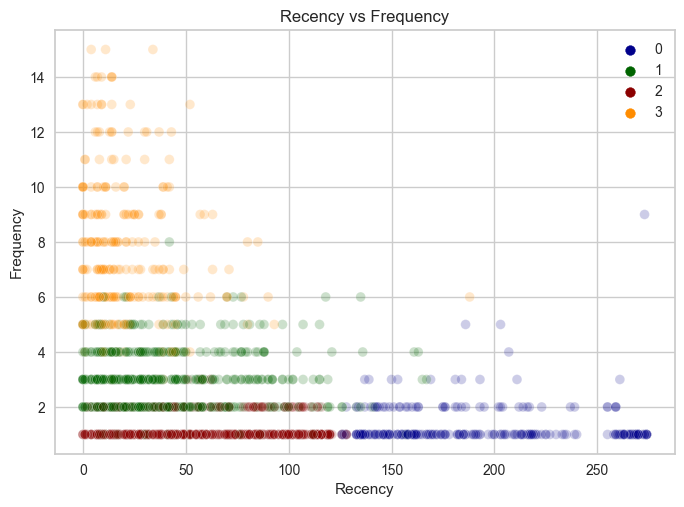

In [36]:
palette = ['darkblue', 'darkgreen', 'darkred', 'darkorange']
sns.scatterplot(data=df_no_outlier, x='Recency', y='Frequency', hue='Cluster', palette=palette, alpha=0.2)
plt.title('Recency vs Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()
plt.show()

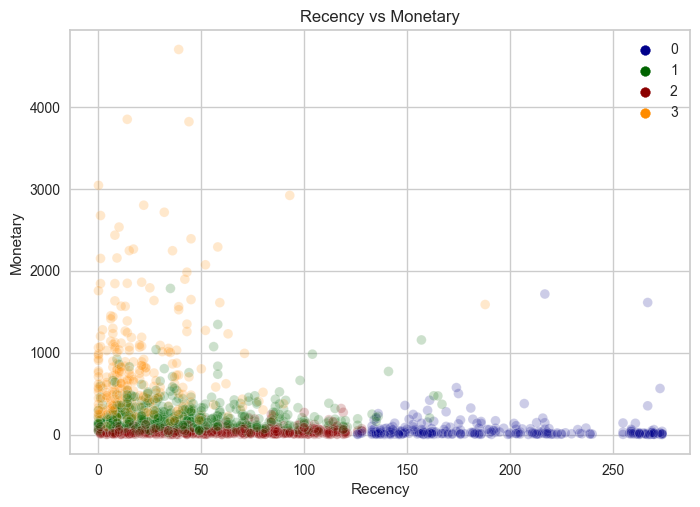

In [37]:
sns.scatterplot(data=df_no_outlier, x='Recency', y='Monetary', hue='Cluster', palette=palette, alpha=0.2)
plt.title('Recency vs Monetary')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend()
plt.show()

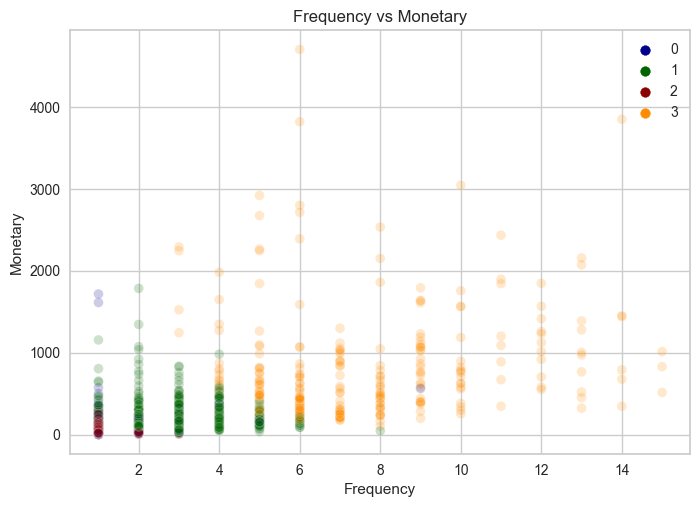

In [38]:
sns.scatterplot(data=df_no_outlier, x='Frequency', y='Monetary', hue='Cluster', palette=palette, alpha=0.2)
plt.title('Frequency vs Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend()
plt.show()

In [39]:
df_no_outlier[df_no_outlier['Cluster'] == 0].describe()

Recency   Frequency     Monetary  Cluster
count  267.000000  267.000000   267.000000    267.0
mean   192.067416    1.322097    64.031610      0.0
std     46.543729    0.785918   163.882893      0.0
min    126.000000    1.000000     0.420000      0.0
25%    153.000000    1.000000     8.550000      0.0
50%    182.000000    1.000000    19.350000      0.0
75%    223.000000    1.000000    60.000000      0.0
max    274.000000    9.000000  1715.850000      0.0

In [40]:
df_no_outlier[df_no_outlier['Cluster'] == 1].describe()

Recency   Frequency     Monetary  Cluster
count  584.000000  584.000000   584.000000    584.0
mean    41.179795    2.907534   207.315051      1.0
std     32.417149    1.096546   181.235507      0.0
min      0.000000    1.000000    18.120000      1.0
25%     16.000000    2.000000    93.325000      1.0
50%     34.000000    3.000000   159.390000      1.0
75%     58.000000    4.000000   246.195000      1.0
max    167.000000    8.000000  1784.080000      1.0

In [41]:
df_no_outlier[df_no_outlier['Cluster'] == 2].describe()

Recency   Frequency    Monetary  Cluster
count  528.000000  528.000000  528.000000    528.0
mean    60.744318    1.170455   41.388390      2.0
std     36.302662    0.391220   40.717495      0.0
min      0.000000    1.000000    0.420000      2.0
25%     28.000000    1.000000   15.112500      2.0
50%     59.500000    1.000000   31.250000      2.0
75%     92.000000    1.000000   53.417500      2.0
max    128.000000    3.000000  317.700000      2.0

In [42]:
df_no_outlier[df_no_outlier['Cluster'] == 3].describe()

Recency   Frequency     Monetary  Cluster
count  266.000000  266.000000   266.000000    266.0
mean    20.800752    7.650376   825.054511      3.0
std     21.279314    2.646810   679.648141      0.0
min      0.000000    3.000000   101.060000      3.0
25%      7.000000    6.000000   374.687500      3.0
50%     14.000000    7.000000   618.525000      3.0
75%     28.750000    9.000000  1028.592500      3.0
max    188.000000   15.000000  4702.440000      3.0

We have pretty clear clusters:
- Cluster 0: Customers who does not order often (low frequency, usually 1 order), for a low value (around £10 to £60 in the timeframe) and not recently (more than 125 days) ; 267 customers,

- Cluster 1: Customers who order rather often (medium to high frequency, up to 4 orders), for a medium value (between £90 and £250 in the timeframe) and very recently (less than 60 days) ; 584 customers,

- Cluster 2: Customers who does not order often (low frequency, usually 1 order), for a low value (around £15 to £55 in the timeframe) and recently (less than 125 days) ; 528 customers,

- Cluster 3: Customers who order very often (high frequency, more than 6 orders), for a high value (between £100 and £1000 in the timeframe) and very recently (less than 50 days, most are within the month) ; 266 customers.